<a href="https://colab.research.google.com/github/grigorjevas/Discogs-price-prediction/blob/main/Preparing_data_and_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Discogs Marketplace price predictions

## EDA and selecting data

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import pickle

In [87]:
df = pd.read_csv("/content/drive/MyDrive/Data/electro_raw_data.csv", parse_dates=["release_date"], na_values="N/A")

In [88]:
df.head()

,artist,title,label,release_format,number_of_tracks,release_date,price,rating,votes,have,want,limited_edition,media_condition,sleeve_condition,release_page
0,Quintron And Miss Pussycat,Live At Third Man Records,Third Man Records ‎– TMR 147,LP,10,2012-03-12,19.00,5.00,1.0,9,10,0,Mint (M),Mint (M),https://discogs.com/Quintron-And-Miss-Pussycat...
1,Jean-Michel Jarre,The Concerts In China,"PGP RTB ‎– 3220117, Polydor ‎– DLP 2612 039",LP,15,1982-01-01,21.27,4.00,23.0,204,53,0,Very Good Plus (VG+),Very Good (VG),https://discogs.com/Jean-Michel-Jarre-The-Conc...
2,MC T-Rock,Introducing,M-Pire Records ‎– MPR 9901.4,"12""",4,1999-01-01,21.34,4.42,24.0,107,78,0,Very Good Plus (VG+),Generic,https://discogs.com/MC-T-Rock-Introducing/rele...
3,E.T.M.S.,Sounds Of Humanoid Kind,Musix Records ‎– SMX 11004,"12""",13,1983-01-01,24.19,4.40,72.0,256,267,1,Very Good Plus (VG+),Very Good Plus (VG+),https://discogs.com/ETMS-Sounds-Of-Humanoid-Ki...
4,The Art Of Noise,In Visible Silence,"Chrysalis ‎– BFV 41528, China Records ‎– BFV 4...",LP,11,1986-01-01,24.14,4.01,109.0,896,123,0,Very Good Plus (VG+),Very Good Plus (VG+),https://discogs.com/The-Art-Of-Noise-In-Visibl...


In [89]:
df.shape

(4998, 15)

Convert release date to year

In [90]:
df["release_year"] = df['release_date'].dt.year

Only keep records priced under 100 eur

In [91]:
df = df[df["price"] < 100]

Parse item condition to numerical values

In [92]:
# Parses item condition value to numerical values
def parse_item_condition_to_int(condition: str) -> int:
    return {
        "Poor (P)": 0,
        "Fair (F)": 0,
        "Good (G)": 1,
        "Good Plus (G+)": 1,
        "Very Good (VG)": 2,
        "Very Good Plus (VG+)": 3,
        "Generic": 3,
        "Not Graded": 3,
        "No Cover": 3,
        "Near Mint (NM or M-)": 4,
        "Mint (M)": 5
    }[condition]

In [93]:
df["media_condition"] = df["media_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))
df["sleeve_condition"] = df["sleeve_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))

Drop N/A rows 

In [94]:
df = df.dropna()

Drop unneeded columns

In [95]:
df = df.drop(["artist", "title", "label", "release_date", "release_page"], axis="columns")

In [96]:
df.head()

,release_format,number_of_tracks,price,rating,votes,have,want,limited_edition,media_condition,sleeve_condition,release_year
0,LP,10,19.00,5.00,1.0,9,10,0,5,5,2012.0
1,LP,15,21.27,4.00,23.0,204,53,0,3,2,1982.0
2,"12""",4,21.34,4.42,24.0,107,78,0,3,3,1999.0
3,"12""",13,24.19,4.40,72.0,256,267,1,3,3,1983.0
4,LP,11,24.14,4.01,109.0,896,123,0,3,3,1986.0


In [97]:
df.shape

(4835, 11)

## Encoding and scaling data 

In [98]:
one_hot_encoder = OneHotEncoder().fit(df[["release_format"]])

In [99]:
encoded_data = one_hot_encoder.transform(df[["release_format"]]).todense()

In [100]:
scaler = StandardScaler().fit(
    df.drop(["release_format", "price"], axis="columns"))

In [101]:
scaled_data = scaler.transform(
    df.drop(["release_format", "price"], axis="columns"))

In [102]:
encoded_features = np.concatenate([encoded_data, scaled_data], axis=-1)

In [103]:
train_features, test_features, train_price, test_price = train_test_split(
    encoded_features, df["price"]
)

## Training the model

In [104]:
model = LinearRegression(fit_intercept=False)
model.fit(train_features, train_price)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

## Evaluating the model

In [105]:
score = model.score(test_features, test_price)
predicted = model.predict(test_features)
mae = metrics.mean_absolute_error(test_price, predicted)
print(f"Model score: {score}")
print(f"Mean absolute error: {mae}")

Model score: 0.5254380568688232
Mean absolute error: 2.1076547256012557


Text(0, 0.5, 'Predicted price')

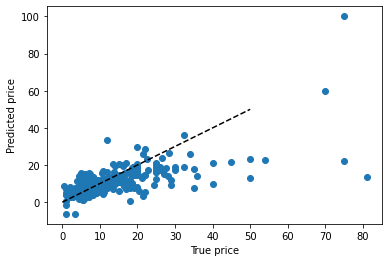

In [106]:
expected = test_price
plt.scatter(expected, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')

## Exporting the models

In [107]:
with open("model.pkl", "wb") as f:
  pickle.dump(model, f)

In [108]:
with open("one_hot_encoder.pkl", "wb") as f:
  pickle.dump(one_hot_encoder, f)

In [109]:
with open("scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)